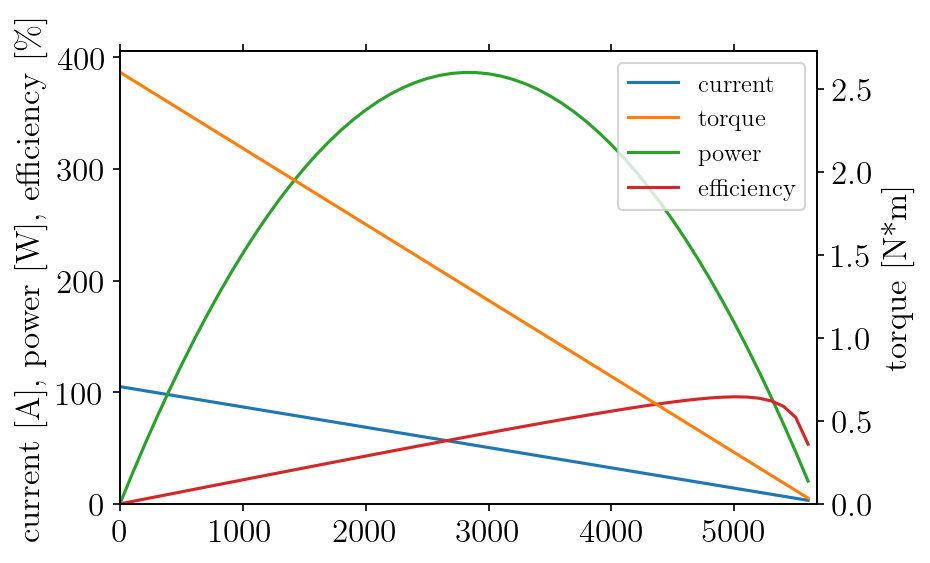

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'interactive':True, 'text.usetex':True, 'font.size':16, 'font.family':['serif'], 'font.serif':['Computer Modern Roman'], 'axes.grid':False, 'axes.facecolor':'none', 'legend.facecolor':'white', 'xtick.top':True, 'ytick.right':True, 'figure.dpi':150, 'image.interpolation':'none', 'image.cmap':'bwr'})
ticker = plt.matplotlib.ticker
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

class gears:
    def __init__(self, sprrat, planrat):
        self.sprrat = sprrat # sprocket ratio
        self.planrat = planrat # planetary ratio
        self.grat = self.sprrat * self.planrat
        return None

class motor:
    def __init__(self, omega_free, i_free, i_stall, tau_stall):
        self.omega_free = omega_free
        self.i_free = i_free
        self.i_stall = i_stall
        self.tau_stall = tau_stall
        self.omega_shaft = np.arange(0, self.omega_free, 100)
        self.i = self.i_free + (self.i_stall - self.i_free)*(1 - self.omega_shaft / self.omega_free)
        self.tau = self.tau_stall * (1 - self.omega_shaft / self.omega_free)
        self.P = self.tau * (self.omega_shaft * 2*np.pi/60.) # N*m * rad/sec = J/s = W
        self.eff = self.P / (12 * self.i) * 100 # assumes 12 V
        return None
    
    def motspeed(self, tau_arm, gear):
        tau_inp = tau_arm / gear.grat # N*m, torque at motor shaft
        omega_inp = np.interp(-tau_inp, -self.tau, self.omega_shaft) # rpm with shaft torque at tau_shaft
        eff_inp = np.interp(omega_inp, self.omega_shaft, self.eff) # %
        i_inp = np.interp(omega_inp, self.omega_shaft, self.i) # A, current at tau_shaft
        omega_out = omega_inp / gear.grat
        return {'tau_inp':tau_inp, 'omega_inp':omega_inp, 'eff_inp':eff_inp, 'i_inp':i_inp, 'omega_out':omega_out}

    def plot(self):
        fig,ax0 = plt.subplots()
        ax1 = ax0.twinx()
        ax0.plot(self.omega_shaft, self.i, c=cols[0])
        ax0.plot([0],[0], c=cols[1])
        ax0.plot(self.omega_shaft, self.P, c=cols[2])
        ax0.plot(self.omega_shaft, self.eff, c=cols[3])
        ax1.plot(self.omega_shaft, self.tau, c=cols[1])
        ax0.set_ylabel('current [A], power [W], efficiency [\%]')
        ax1.set_ylabel('torque [N*m]')
        ax0.legend(['current','torque','power','efficiency'], loc='upper right', fontsize=12)
        ax0.set_xlim(left=0, right=self.omega_free)
        ax0.set_ylim(bottom=0) ; ax1.set_ylim(bottom=0)
        return fig,ax0,ax1
        
neo = motor(omega_free=5676, i_free=1.8, i_stall=105, tau_stall=2.6)
neo.plot()
max125 = gears(sprrat=48/15., planrat=5*5*5)

In [2]:
dxrung = 24. # inches
dyrung = 15.375 # inches
psinextr = np.pi - np.arctan(dxrung / dyrung) ; psinext = psinextr*180/np.pi
r0 = np.hypot(dyrung, dxrung)/2.
r = r0 + 2.75
l = np.arange(30, 45+1, 5)
th = np.arange(361) ; thr = th * np.pi/180.
h = np.sqrt(r**2+l[:,None]**2-2*r*l[:,None]*np.cos(thr)[None,:])
psir = np.arctan2(np.sin(thr)[None,:]*l[:,None]/h, (r**2+h**2-l[:,None]**2)/(2*r*h)) ; psi = psir * 180/np.pi
thnext = np.array([np.interp(-psinext, -psi[i], th) for i in range(l.size)])
psi2 = np.array([np.interp(180+thnext[i], th, psi[i]) for i in range(l.size)])
dhdthr = r*l[:,None]*np.sin(thr)[None,:]/h ; dhdth = dhdthr * np.pi/180. # height per radian, height per deg
phir = np.arctan2(np.sin(thr)[None,:]*r/h, (h**2+l[:,None]**2-r**2)/(2*r*l[:,None])) ; phi = phir * 180/np.pi

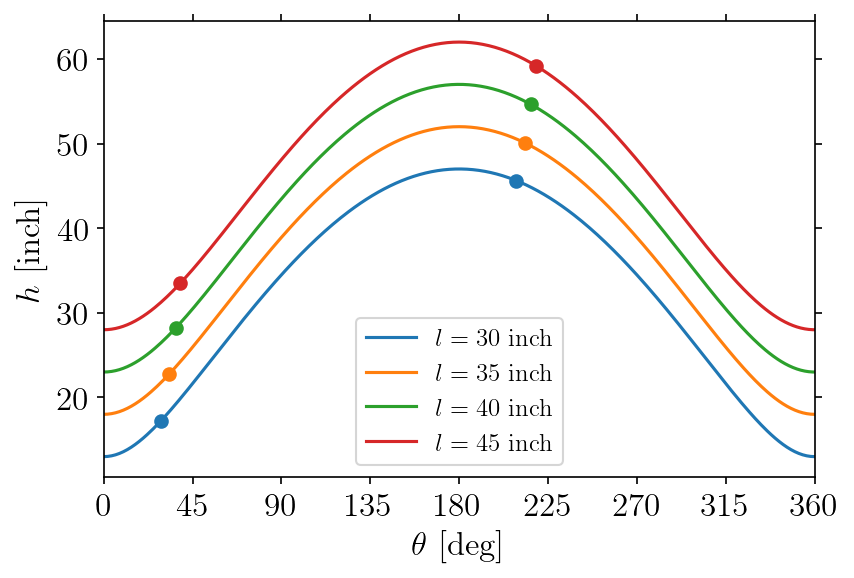

In [3]:
dum = [plt.plot(th, h[i]) for i in range(l.size)]
dum = [plt.plot(thnext[i], np.interp(thnext[i], th, h[i]), marker='o', c=cols[i]) for i in range(l.size)]
dum = [plt.plot(180+thnext[i], np.interp(180+thnext[i], th, h[i]), marker='o', c=cols[i]) for i in range(l.size)]
plt.xlim(left=0,right=360)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(base=45))
plt.xlabel(r'$\theta$ [deg]') ; plt.ylabel(r'$h$ [inch]')
plt.gca().set_position([0.16, 0.17, 0.79, 0.76])
plt.legend(['$l = %d$ inch' % (i,) for i in l], fontsize=12)

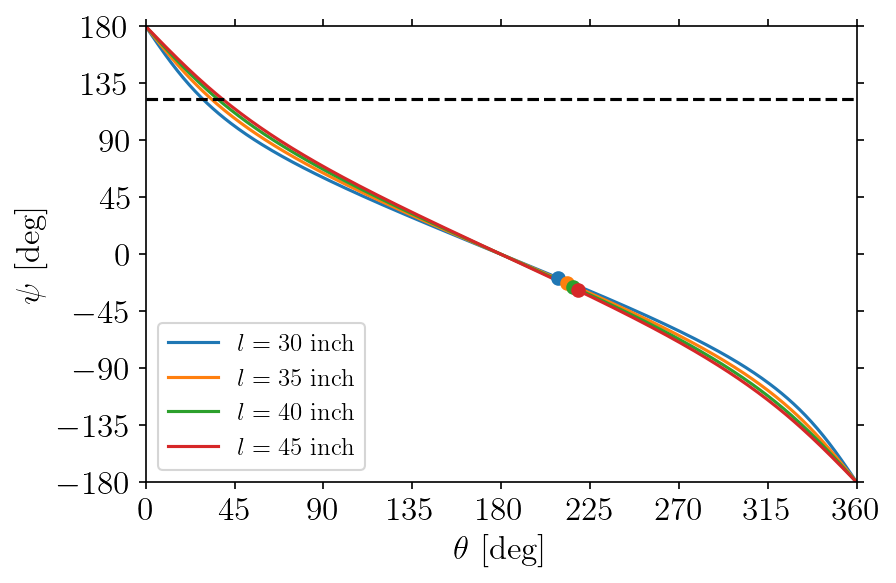

In [4]:
dum = [plt.plot(th, psi[i]) for i in range(l.size)]
plt.axhline(psinext, c='k', ls='--')
dum = [plt.plot(180+thnext[i], psi2[i], marker='o', c=cols[i]) for i in range(l.size)]
plt.axis([0,360,-180,180])
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(base=45))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(base=45))
plt.xlabel(r'$\theta$ [deg]') ; plt.ylabel(r'$\psi$ [deg]')
plt.gca().set_position([0.16, 0.17, 0.79, 0.76])
plt.legend(['$l = %d$ inch' % (i,) for i in l], fontsize=12)

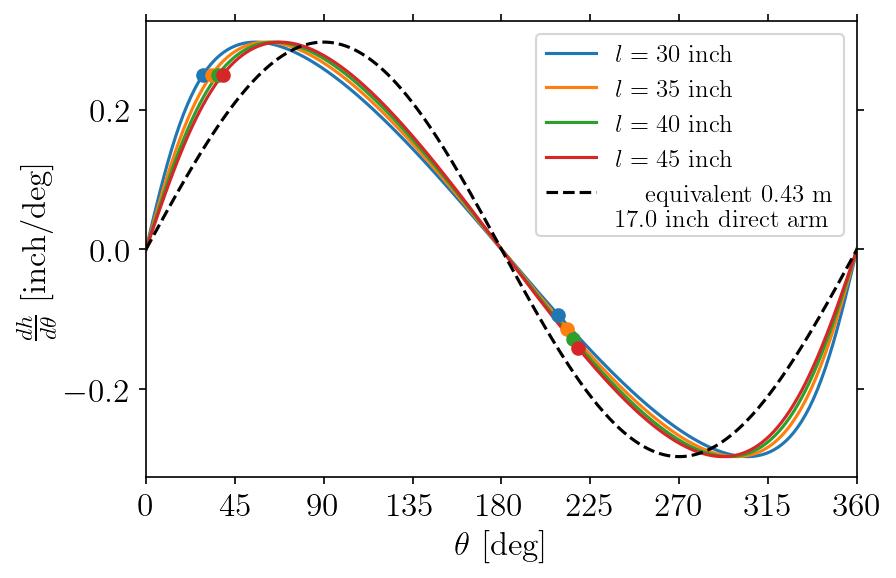

In [5]:
dum = [plt.plot(th, dhdth[i]) for i in range(l.size)]
plt.plot(th, dhdth[1].max() * np.sin(thr), c='k', ls='--')
dum = [plt.plot(thnext[i], np.interp(thnext[i], th, dhdth[i]), marker='o', c=cols[i]) for i in range(l.size)]
dum = [plt.plot(180+thnext[i], np.interp(180+thnext[i], th, dhdth[i]), marker='o', c=cols[i]) for i in range(l.size)]
plt.xlim(left=0, right=360)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(base=45))
plt.xlabel(r'$\theta$ [deg]') ; plt.ylabel(r'$\frac{dh}{d\theta}$ [inch/deg]')
plt.gca().set_position([0.16, 0.17, 0.79, 0.76])
plt.legend(['$l = %d$ inch' % (i,) for i in l] + [r'equivalent %.2f m\\%.1f inch direct arm' % (dhdthr[1].max() * 0.0254, dhdthr[1].max())], fontsize=12)

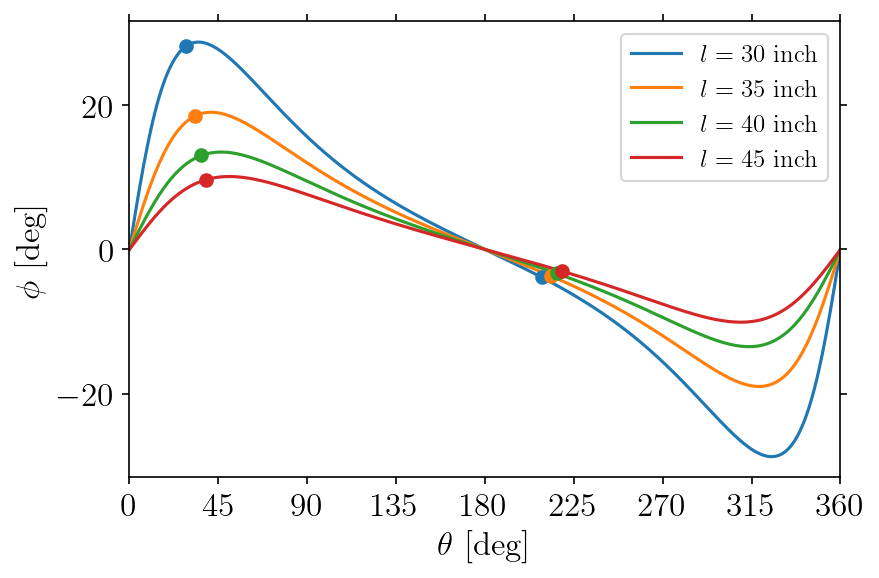

In [6]:
dum = [plt.plot(th, phi[i]) for i in range(l.size)]
dum = [plt.plot(thnext[i], np.interp(thnext[i], th, phi[i]), marker='o', c=cols[i]) for i in range(l.size)]
dum = [plt.plot(180+thnext[i], np.interp(180+thnext[i], th, phi[i]), marker='o', c=cols[i]) for i in range(l.size)]
plt.xlim(left=0, right=360)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(base=45))
plt.xlabel(r'$\theta$ [deg]') ; plt.ylabel(r'$\phi$ [deg]')
plt.gca().set_position([0.16, 0.17, 0.79, 0.76])
plt.legend(['$l = %d$ inch' % (i,) for i in l], fontsize=12)

In [7]:
dhdthr[1].max() * np.pi/180. # inch / deg

0.29672733012173835

In [8]:
req = dhdthr[1].max() * 0.0254 ; req # m / rad, equivalent lever arm in m

0.431831081526882

In [9]:
dhdthr[1].max() # inch / rad, equivalent lever arm in inch

17.00122368216071

In [10]:
mtot = 150 / 2.205 ; mtot # kg total

68.02721088435374

In [11]:
mperarm = mtot / 2. ; mperarm # kg per arm

34.01360544217687

In [12]:
wtperarm = mperarm * 9.8 ; wtperarm # N (gravity = 9.8 m/s^2)

333.3333333333333

In [13]:
tau_armpk = req * wtperarm ; tau_armpk # N*m peak at arm

143.94369384229398

In [14]:
spneo125pk = neo.motspeed(tau_armpk, max125) ; spneo125pk

{'tau_inp': 0.35985923460573493,
 'omega_inp': 4890.399609376096,
 'eff_inp': 95.47159623454891,
 'i_inp': 16.083643465889164,
 'omega_out': 12.22599902344024}

In [15]:
spneo125pk['omega_out'] / 60, 60 / spneo125pk['omega_out'] 

(0.20376665039067066, 4.907574414570562)

In [16]:
max75 = gears(sprrat=48/15., planrat=5*5*3)
spneo75pk = neo.motspeed(tau_armpk, max75) ; spneo75pk

{'tau_inp': 0.5997653910095583,
 'omega_inp': 4366.666015626826,
 'eff_inp': 89.24588332788885,
 'i_inp': 25.606072443148612,
 'omega_out': 18.194441731778443}

In [17]:
spneo75pk['omega_out'] / 60, 60 / spneo75pk['omega_out']

(0.3032406955296407, 3.2977104153299686)

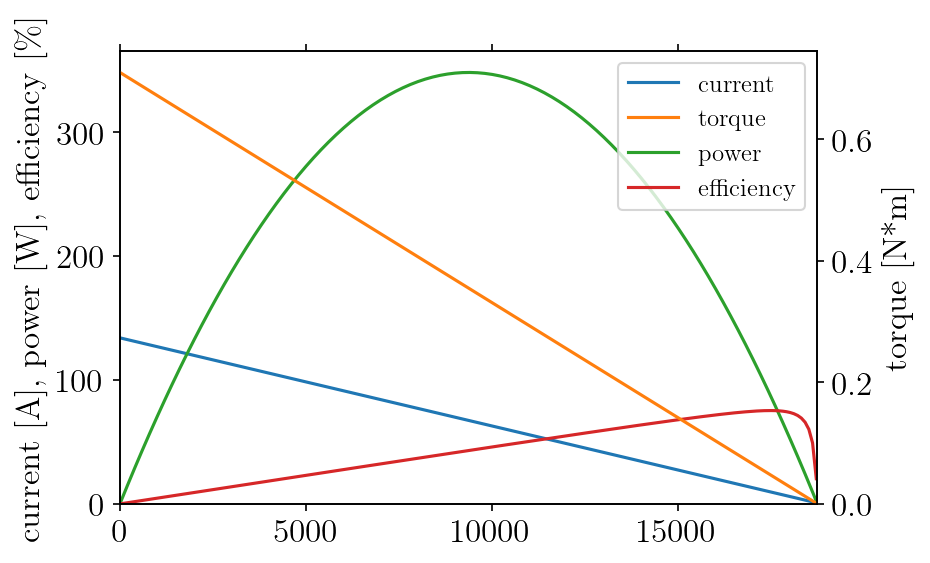

In [18]:
pro775 = motor(omega_free=18730, i_free=0.7, i_stall=134, tau_stall=0.71)
pro775.plot()
versa200 = gears(sprrat=48./15, planrat=9*7*3)

In [19]:
sp775_200pk = pro775.motspeed(tau_armpk, versa200) ; sp775_200pk

{'tau_inp': 0.23800213928950723,
 'omega_inp': 12451.436522686661,
 'eff_inp': 56.982786211366154,
 'i_inp': 45.38406361590327,
 'omega_out': 20.587692663172387}

In [20]:
sp775_200pk['omega_out'] / 60, 60 / sp775_200pk['omega_out']

(0.3431282110528731, 2.9143625262742052)

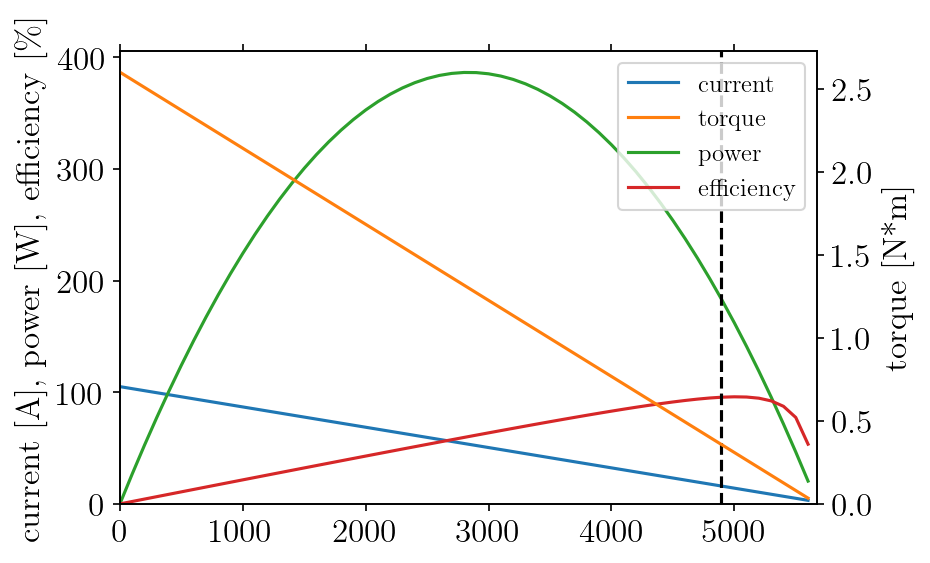

In [21]:
fig, ax0, ax1 = neo.plot()
ax0.axvline(spneo125pk['omega_inp'], c='k', ls='--')

In [22]:
tau_all = wtperarm * dhdthr[1]*0.0254
spneo125all = [neo.motspeed(t, max125) for t in tau_all]

In [23]:
spneo125all[30]

{'tau_inp': 0.2864303317658162,
 'omega_inp': 5050.70055265278,
 'eff_inp': 95.7826225069798,
 'i_inp': 13.169080860858546,
 'omega_out': 12.62675138163195}

In [24]:
spneo125all[230]

{'tau_inp': -0.20210699766529164,
 'omega_inp': 5600.0,
 'eff_inp': 53.46931165799682,
 'i_inp': 3.1818181818181825,
 'omega_out': 14.0}

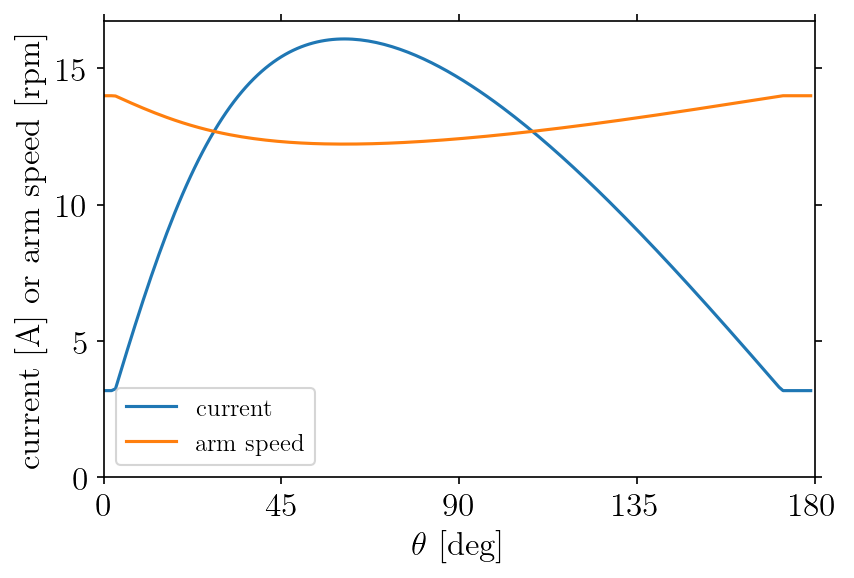

In [27]:
plt.plot(th[:180], [s['i_inp'] for s in spneo125all[:180]])
plt.plot(th[:180], [s['omega_out'] for s in spneo125all[:180]])
plt.xlim(left=0, right=180)
plt.ylim(bottom=0)
plt.legend(['current', 'arm speed'], fontsize=12)
plt.xlabel(r'$\theta$ [deg]') ; plt.ylabel('current [A] or arm speed [rpm]')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(base=45))
plt.gca().set_position([0.16, 0.17, 0.79, 0.76])

In [155]:
dt = 1. / (np.array([s['omega_out'] for s in spneo125all]) * 360/60) # seconds per degree

In [156]:
dt[50]

0.013587684815185222

In [157]:
dt[:180].sum()

2.324299244567261

In [166]:
thnext[1] # this is the theta where we latch onto the next rung

33.21345313668519

In [168]:
dt[33:180].sum() + 33*dt[180]# this is the time for a 180, neo125; time to do 33 deg at max speed (go from 33*180 to 33, dropping CG), plus the time to go from 180 down to 33 (raising CG)

2.3017876983027774

In [160]:
dt[33:180].sum()

1.9089305554456344

In [169]:
spneo75all = [neo.motspeed(t, max75) for t in tau_all]
dt75 = 1. / (np.array([s['omega_out'] for s in spneo75all]) * 360/60) # seconds per degree
dt75[33:180].sum(), dt75[33:180].sum() + 33*dt75[180] # time for neo75 to go from vertical to next, and to do 180

(1.2351922293181123, 1.470906515032398)

Text(0, 0.5, 'A or rpm')

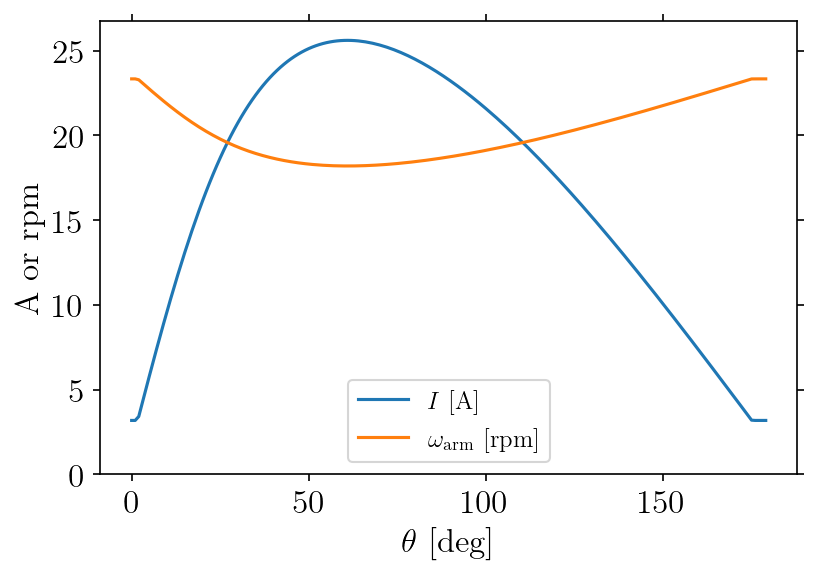

In [164]:
plt.plot(th[:180], [s['i_inp'] for s in spneo75all[:180]])
plt.plot(th[:180], [s['omega_out'] for s in spneo75all[:180]])
plt.ylim(bottom=0)
plt.legend(['$I$ [A]', r'$\omega_{\rm arm}$ [rpm]'], fontsize=12)
plt.xlabel(r'$\theta$ [deg]') ; plt.ylabel(r'A or rpm')

In [28]:
spneo75pk

{'tau_inp': 0.5997653910095583,
 'omega_inp': 4366.666015626826,
 'eff_inp': 89.24588332788885,
 'i_inp': 25.606072443148612,
 'omega_out': 18.194441731778443}

In [29]:
max75.grat

240.0

In [30]:
spneo75pk['tau_inp'] * max75.grat

143.94369384229398